In [1]:
%matplotlib inline
#computation
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
# pl.rc("figure", facecolor="white",figsize = (3,2))
pl.rc("figure", facecolor="gray",figsize = (8,8))

pl.rc('text', usetex=True)
pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 12)
# params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
# pyplot.rcParams.update(params)

#utils
# import time
# from copy import deepcopy
# from functools import partial
# import itertools
# from importlib import reload

#notebook config
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Math

from itertools import product
from scipy import special

In [2]:
import scipy.io as spio
mat = spio.loadmat('LIPdata.mat', squeeze_me=True)

In [3]:
col_names=mat['LIPdata'].flatten().dtype.names
col_names

('spikes',
 'pre_dot_time',
 'datatype',
 'pulip',
 'coh',
 'direction',
 'numtargs',
 'rts',
 'numtrials',
 'phi')

In [4]:
df_data=pd.DataFrame(columns=col_names)
for col_name in col_names:
    df_data[col_name]=mat['LIPdata'].flatten()[col_name]
df_data.head()

,spikes,pre_dot_time,datatype,pulip,coh,direction,numtargs,rts,numtrials,phi
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",200,monkey,1,1,1,2,"[720.5500000000029, 1026.7750000000087, 669.45...",77,0.916071
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",200,monkey,1,1,7,4,"[934.4500000000007, 837.4750000000004, 869.925...",153,0.916071
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",200,monkey,2,1,1,2,"[721.5999999999995, 591.75, 554.75, 294.050000...",45,0.979799
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",200,monkey,2,1,7,4,"[466.875, 562.7750000000233, 641.625, 405.9249...",77,0.979799
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",200,monkey,3,1,1,2,"[595.75, 533.7749999999942, 690.6499999999651,...",14,1.0752


In [5]:
df_data.loc[df_data['numtargs']==2].rts

0      [720.5500000000029, 1026.7750000000087, 669.45...
2      [721.5999999999995, 591.75, 554.75, 294.050000...
4      [595.75, 533.7749999999942, 690.6499999999651,...
6      [529.7749999999942, 572.75, 449.7750000000233,...
8      [597.5999999940395, 691.0, 682.5999999940395, ...
                             ...                        
128    [592.7250000000058, 883.8500000000058, 923.899...
130    [701.6000000000058, 527.7749999999942, 1044.82...
132    [613.7000000000116, 468.875, 661.6499999999942...
134    [356.9250000000029, 289.54999999998836, 379.94...
136    [303.54999999999563, 328.0, 332.0, 447.875, 39...
Name: rts, Length: 69, dtype: object

These are the distribution of all reaction times:

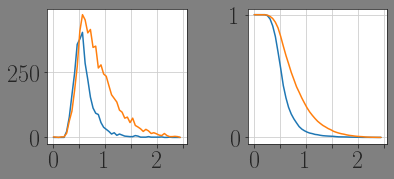

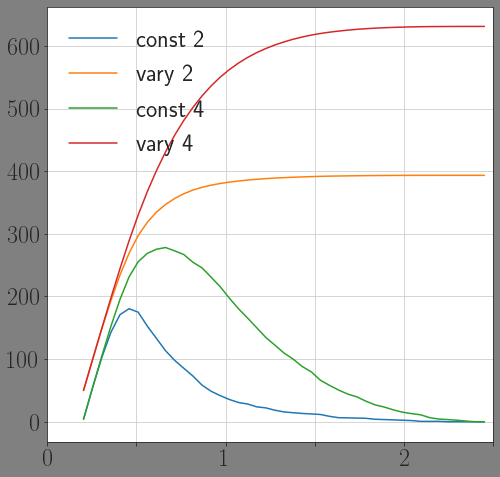

In [6]:
fig1,ax1=pl.subplots(1,2,figsize=(6,3))
fig2,ax2=pl.subplots(1,1)
for task in (2,4):
    time_store=[]
    for idx,times in df_data.loc[df_data['numtargs']==task].rts.items():
        time_store=time_store+list(times)
    counts,bins=np.histogram(time_store,np.linspace(0,2500,50))
    ax1[0].plot(bins[:-1]/1000,counts)
    surv_func=1-np.cumsum(counts)/np.sum(counts)
    ax1[1].plot(bins[:-1]/1000,surv_func)
    ax2.plot(bins[:-1][bins[:-1]>200]/1000,surv_func[bins[:-1]>200]*(bins[:-1][bins[:-1]>200]-200),label='const '+str(task))
    ax2.plot(bins[:-1][bins[:-1]>200]/1000,np.cumsum(surv_func[bins[:-1]>200]*(2500/50)),label='vary '+str(task))
ax2.set_xlim(200/1000,700/1000)
ax1[0].set_xticks([0,0.5,1,1.5,2,2.5])
ax1[0].set_xticklabels([r'$0$','',r'$1$','',r'$2$',''])
ax1[1].set_xticklabels([r'$0$','',r'$1$','',r'$2$',''])
ax1[1].set_xticks([0,0.5,1,1.5,2,2.5])
ax2.set_xticks([0,0.5,1,1.5,2,2.5])
ax2.set_xticklabels([r'$0$','',r'$1$','',r'$2$',''])
ax2.legend(frameon=False)
# ax2.set_ylim(0,8)
fig1.tight_layout()

In lieu of performance on individual trials, I'm using average preformance (per cell), if that is phi, plotted against the mean reaction time...

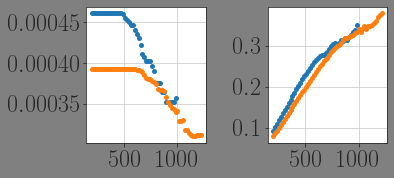

In [7]:
fig,ax=pl.subplots(1,2,figsize=(6,3))
tvecdense=np.linspace(200,2000,100)
for task in (2,4):
    avg_times=df_data.loc[df_data['numtargs']==task].rts.apply(lambda x: np.mean(x))
    P_corr=1/(1+np.exp(-df_data.loc[df_data['numtargs']==task].phi.values.astype('float')))
    RR=P_corr/(avg_times+700)
    posterior_mean=[np.mean(RR[avg_times>t]) for t in tvecdense]
    ax[0].plot(tvecdense,posterior_mean,'.')
    ax[1].plot(tvecdense,posterior_mean*tvecdense,'.')
fig.tight_layout()

In [ ]:
block_times=[150,50]
T_ITI=7.5 #1500 ms with 200ms steps
T=15
# for mon in range(1,3):


df_data['T_trial']=(df_data.tDecision.values+(df_data.nPostInterval/200.)*(T-df_data.tDecision.values)+T_ITI)
df_data['RR']=df_data.pcorratDectime/df_data.T_trial

tcount_store=[]
rcount_store=[]
tbinvec=np.arange(16)
rbinvec=np.linspace(0.02,0.07,40)

for post_interval in block_times:
    counts,bins=np.histogram(df_data[df_data.nPostInterval==post_interval].tDecision,bins=tbinvec)
    tcount_store.append(counts)
    
    counts,bins=np.histogram(df_data[df_data.nPostInterval==post_interval].RR,bins=rbinvec)
    rcount_store.append(counts)

In [12]:
df_data[df_data['numtargs']==task].RR

0      [0.00041512354843590464, 0.0003524026205481091...
2      [0.0004223212511685254, 0.00045677290153085164...
4      [0.00046723182561085987, 0.0004861111869202017...
6      [0.00042221407981678574, 0.0004106771857903169...
8      [0.0003850812758640198, 0.00036381185471204183...
                             ...                        
128    [0.0003630396874998259, 0.000306936532246814, ...
130    [0.00035246009009018734, 0.0003925617903797792...
132    [0.0004169047132768042, 0.0004580097937637878,...
134    [0.00044991046180022657, 0.0004734168922323905...
136    [0.0004704029386625021, 0.0004617422821487218,...
Name: RR, Length: 69, dtype: object

In [82]:
df_data['RT_avg']=df_data.rts.apply(lambda x: np.mean(x))/1000
df_data['P_corr']=1/(1+np.exp(-df_data.phi.values.astype('float')))
df_data['RR']=df_data.P_corr/(df_data.RT_avg+1.7)

tcount_store=[]
rcount_store=[]
tmax=3
tbinvec=np.linspace(0,tmax,40)
rbinvec=np.linspace(0,0.5,40)
meanT_store=[]
for task in (2,4):
    data=df_data[df_data['numtargs']==task]
    RTs=data.rts.explode()
    meanT_store.append(RTs.mean()/1000)
    counts,bins=np.histogram(RTs.values/1000,bins=tbinvec)
    tcount_store.append(counts)
    
    counts,bins=np.histogram(data.RR.values,bins=rbinvec)
    rcount_store.append(counts)

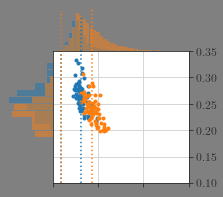

In [85]:
fig,ax=pl.subplots(nrows=2, ncols=2, gridspec_kw={'width_ratios':[1,3], 'height_ratios':[1,3]},figsize=(3.25,3.25))#,hspace=0, wspace=0)
ax[0,0].axis('off')
ax_corr=ax[1,1]
ax_rew=ax[1,0]
ax_times=ax[0,1]
ax_corr.yaxis.tick_right()
ax_corr.set_ylim(0.1,0.35)
ax_corr.set_xlim(0,tmax)
ax_corr.set_xticklabels([])

ax_rew.set_yticks([])
ax_rew.invert_xaxis()
ax_rew.axis('off')
ax_rew.set_ylim(0.1,0.35)

ax_times.set_yticks([])
ax_times.set_xticks([])
ax_times.axis('off')
ax_times.set_xlim(0,tmax)
offsetvec=[0.05,0.05]
bar_width=0.9
start_time=0.19
for tit,task in enumerate([2,4]):
    data=df_data.loc[df_data['numtargs']==task]
    mean_T=data.rts
    ax_corr.scatter(data.RT_avg,data.RR,marker='.')#,clip_on=False)
    ax_corr.plot([start_time]*2,ax_corr.get_ylim(),':',color='C'+str(tit))
    ax_corr.plot([meanT_store[tit]]*2,ax_corr.get_ylim(),':',color='C'+str(tit))
    ax_rew.barh(rbinvec[:-1]+offsetvec[tit]*(rbinvec[1]-rbinvec[0]),rcount_store[tit],(rbinvec[1]-rbinvec[0])*bar_width,alpha=0.5,edgecolor=None,lw=0)#,color=p[-2][0].get_color())  # Stems
    p=ax_times.bar(tbinvec[:-1]+offsetvec[tit]*(tbinvec[1]-tbinvec[0]),tcount_store[tit],(tbinvec[1]-tbinvec[0])*bar_width,alpha=0.5,edgecolor=None,lw=0)#,color=p[-2][0].get_color())  # Stems
    ax_times.plot([start_time]*2,ax_times.get_ylim(),':',color='C'+str(tit))
    ax_times.plot([meanT_store[tit]]*2,ax_times.get_ylim(),':',color='C'+str(tit))

fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig('primate_RR_RT_corr_rdt.pdf', transparent=True,bbox_inches="tight",dpi=300)

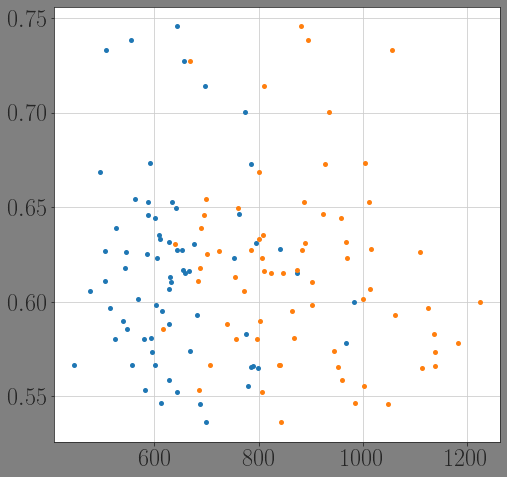

In [9]:
fig,ax=pl.subplots()
for task in (2,4):
    ax.plot(df_data.loc[df_data['numtargs']==task].rts.apply(lambda x: np.mean(x)),1/(1+np.exp(-df_data.loc[df_data['numtargs']==task].phi.values.astype('float'))),'.')

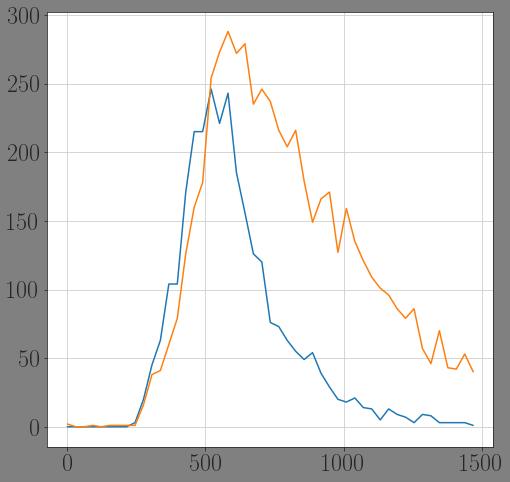

In [10]:
fig,ax=pl.subplots()
for task in (2,4):
    time_store=[]
    for idx,times in df_data.loc[df_data['numtargs']==task].rts.items():
        time_store=time_store+list(times)
    counts,bins=np.histogram(time_store,np.linspace(0,1500,50))
    ax.plot(bins[:-1],counts)